<a href="https://colab.research.google.com/github/Rupaljain27/Hate_Speech_Detection_in_Tweets/blob/main/Improved_Neural_Network_Text_Retrieval_(CSC583)_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd "/content/gdrive/MyDrive/CSC 583 Text Retrieval/Dataset"


/content/gdrive/MyDrive/CSC 583 Text Retrieval/Dataset


In [ ]:
import pandas as pd

In [ ]:
DATA  = "davidson_data.csv"
df = pd.read_csv(DATA)
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


## Data Preprocessing

In [ ]:
df = df[['tweet', 'hate_speech']]
df

,tweet,hate_speech
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0
...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,0
24779,"you've gone and broke the wrong heart baby, an...",0
24780,young buck wanna eat!!.. dat nigguh like I ain...,0
24781,youu got wild bitches tellin you lies,0


## Prepare Model

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#load model
from transformers import BertForSequenceClassification, BertTokenizer

num_labels = 2 # binary classification
model = BertForSequenceClassification.from_pretrained('vinai/bertweet-base',num_labels = num_labels)
# Tell pytorch to run this model on the GPU.
desc = model.cuda()

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertForSequenceClassification: ['roberta.encoder.layer.1.attention.self.value.bias', 'roberta.encoder.layer.4.attention.self.query.weight', 'roberta.encoder.layer.5.attention.self.key.bias', 'lm_head.decoder.weight', 'roberta.encoder.layer.7.attention.self.key.weight', 'roberta.encoder.layer.6.attention.self.key.bias', 'roberta.embeddings.position_ids', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.5.output.LayerNorm.weight', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.2.attention.output.dense.bias', 'roberta.encoder.layer.11.output.dense.weight', 'roberta.encoder.layer.3.intermediate.dense.bias', 'roberta.encoder.layer.0.attention.s

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=True)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Apply Model on Dataset to extract high probability tweets

Token indices sequence length is longer than the specified maximum sequence length for this model (134 > 128). Running this sequence through the model will result in indexing errors


(array([2.2101e+04, 2.5480e+03, 1.0500e+02, 1.6000e+01, 5.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([  3. ,  43.2,  83.4, 123.6, 163.8, 204. , 244.2, 284.4, 324.6,
        364.8, 405. ]),
 <BarContainer object of 10 artists>)

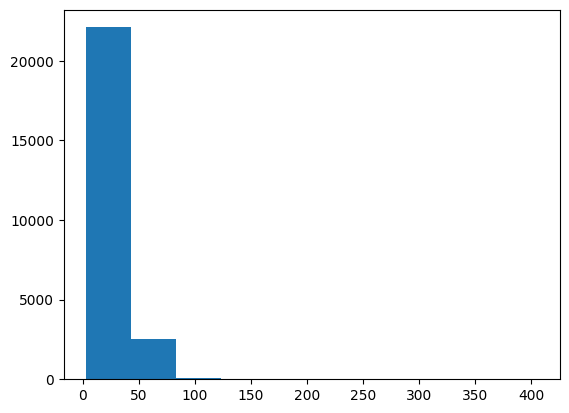

In [ ]:
# check the distribution of number of tokens of the dataset
from matplotlib import pyplot as plt
def check_maxlen(dataframe):
  inputs = {
          "input_ids":[],
          "attention_mask":[]
        }

  sents = dataframe['tweet'].values.tolist()
  lengths = []
  for sent in sents:
    tokenized_input = tokenizer(sent)
    lengths.append(len(tokenized_input["input_ids"]))
    # if len(tokenized_input["input_ids"]) > max_length:
    #   max_length = len(tokenized_input["input_ids"]) 
  
  return lengths

lengths = check_maxlen(df)
plt.hist(lengths)


In [ ]:
#create custom dataset 
import torch
from torch.utils.data import Dataset
class TweetDataset(Dataset):

    def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['label'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
MAX_LENGTH = 128
def create_dataset(dataframe):
  inputs = {
          "input_ids":[],
          "attention_mask":[]
        }

  sents = dataframe['tweet'].values.tolist()
  for sent in sents:
    tokenized_input = tokenizer(sent,max_length=MAX_LENGTH, padding='max_length', truncation = True)
    inputs["input_ids"].append(torch.tensor(tokenized_input["input_ids"]))
    inputs["attention_mask"].append(torch.tensor(tokenized_input["attention_mask"]))

  labels = torch.tensor([0]*dataframe.shape[0])

  return TweetDataset(inputs, labels)

test_dataset = create_dataset(df)


In [ ]:
# Compute predictions using Trainer
from transformers import Trainer, TrainingArguments
test_args = TrainingArguments(
    output_dir = "./result_2e_5",
    do_train = False,
    do_predict = True,
    per_device_eval_batch_size = 16,   
)

trainer = Trainer(model=model, args =test_args)
output = trainer.predict(test_dataset)

In [ ]:
import torch.nn.functional as F
probabilities = F.softmax(torch.from_numpy(output.predictions), dim=-1)

In [ ]:
# sort by high probability
high_prob = torch.max(probabilities, dim = 1)
print(high_prob)

torch.return_types.max(
values=tensor([0.5360, 0.5631, 0.5465,  ..., 0.5480, 0.5570, 0.5631]),
indices=tensor([0, 0, 0,  ..., 0, 0, 0]))


In [ ]:
sorted, index = high_prob.values.sort(descending=True)
print(sorted, index) # we know the index of the tweets that have high prob

tensor([0.5990, 0.5981, 0.5951,  ..., 0.5012, 0.5011, 0.5010]) tensor([ 7348, 24229, 21481,  ..., 11870, 24589, 21076])


Training the model again with Updated Dataset - Improved

In [ ]:
DATA2  = "NN_improve_tweets.csv"
df2 = pd.read_csv(DATA2)
df2

,text,suspicious,cyberbullying,hate,suicidal
0,Uhmm like 6th grade on a corner of a street....,0,0,0,0
1,a) JTP is a douchebag b) Stewart kicks ass!,1,0,0,0
2,ditto bitch!,1,0,0,0
3,damn I have to drive my dad to the airport tha...,0,0,0,0
4,:],0,0,0,0
...,...,...,...,...,...
19929,Happy birthday @paul_lander!,0,0,0,0
19930,RT @MilradJalen: @raesanni I agree it’s awful ...,1,0,0,0
19931,I was called in yesterday at the Guidance Coun...,1,0,0,0
19932,@Jeicky_the_cat @skwi69 Thanks,0,0,0,0


In [ ]:
df2 = df2[['text', 'hate']]
df2

,text,hate
0,Uhmm like 6th grade on a corner of a street....,0
1,a) JTP is a douchebag b) Stewart kicks ass!,0
2,ditto bitch!,0
3,damn I have to drive my dad to the airport tha...,0
4,:],0
...,...,...
19929,Happy birthday @paul_lander!,0
19930,RT @MilradJalen: @raesanni I agree it’s awful ...,0
19931,I was called in yesterday at the Guidance Coun...,0
19932,@Jeicky_the_cat @skwi69 Thanks,0


(array([1.2068e+04, 7.6980e+03, 1.3800e+02, 1.9000e+01, 4.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  3. ,  27.8,  52.6,  77.4, 102.2, 127. , 151.8, 176.6, 201.4,
        226.2, 251. ]),
 <BarContainer object of 10 artists>)

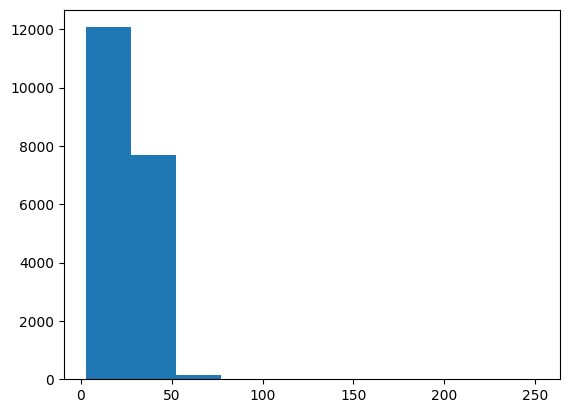

In [ ]:
from matplotlib import pyplot as plt
def check_maxlen_Improved(dataframe):
  inputs = {
          "input_ids":[],
          "attention_mask":[]
        }

  sents = dataframe['text'].values.tolist()
  lengths = []
  for sent in sents:
    tokenized_input = tokenizer(sent)
    lengths.append(len(tokenized_input["input_ids"]))

  return lengths

lengths_improved = check_maxlen_Improved(df2)
plt.hist(lengths_improved)

In [ ]:
import torch

# Encode the text using the BERTweet tokenizer
# encoded_data = tokenizer.batch_encode_plus(
#     df2['text'].tolist(),
#     add_special_tokens=True,
#     return_attention_mask=True,
#     pad_to_max_length=True,
#     max_length=264,
#     return_tensors='pt'
# )
encoded_data = tokenizer.batch_encode_plus(
    df2['text'], 
    padding=True, 
    truncation=True, 
    return_tensors='pt'
    )

# Convert the encoded data to PyTorch tensors
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(df['label'].tolist())

# Create a TensorDataset from the input data
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)



from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2)
train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.2)


In [ ]:
# Split the data into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
# Define the fine-tuning parameters such as the learning rate, batch size, and number of epochs.
from transformers import AdamW, get_linear_schedule_with_warmup

# Define the fine-tuning parameters
batch_size = 16
epochs = 4
learning_rate = 2e-5

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
total_steps = len(train_dataset) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
from transformers import Trainer, TrainingArguments

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=torch.utils.data.TensorDataset(train_inputs, train_masks, train_labels),
    eval_dataset=torch.utils.data.TensorDataset(test_inputs, test_masks, test_labels),
    compute_metrics=lambda pred: {'accuracy': (pred.argmax(axis=1) == test_labels).mean()}
)

# Fine-tune the model
trainer.train()

In [ ]:
# Evaluate the model
trainer.evaluate()